In [1]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def G(x, y, t, omega):
    alpha = np.pi/8
    v = 1
    U = 1

    X = x*np.cos(alpha - np.pi/2) - y*np.sin(alpha - np.pi/2)-U*t
    Y = x*np.sin(alpha - np.pi/2) + y*np.cos(alpha - np.pi/2)

    xi = 2*v*np.sin(alpha)/omega * (np.sin(omega*X/(2*U))- np.sin(-omega*t/2))

    return Y - xi

In [3]:
# Meshgrid
x = np.linspace(0, 10, 200)
y = np.linspace(0, 10, 200)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

In [4]:
# Parameters
rho = 1.0
h = 1.0
s_L = 1.0
epsilon = 0.1  # delta function approximation
omega = 1.0

t = np.linspace(0, 100, 10000)

# Number of samples
N = len(t)

# Sample frequency
Fs = 10000
dt = 1 / Fs

tf = fftfreq(N, dt)

# u input velocity
eps_a = 1
U_bar = 1
Q_bar = 1
St = 1


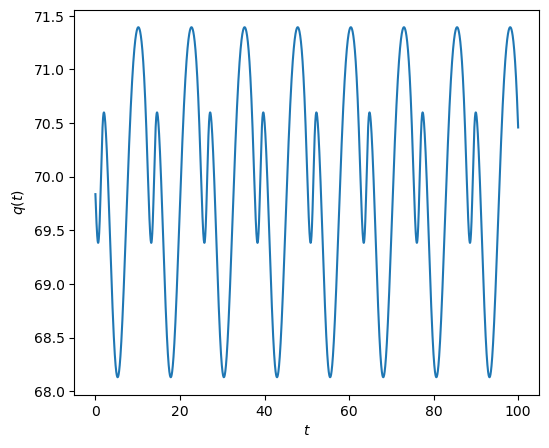

In [5]:

q = [0] * len(t)

for i in range(len(t)):
    Z = G(X, Y, t[i], omega)
    
    # Compute gradients
    dGdx, dGdy = np.gradient(Z, dx, dy)
    gradG = np.sqrt(dGdx**2 + dGdy**2)
    
    # Approximate delta function
    delta_G = (1/(epsilon*np.sqrt(np.pi))) * np.exp(-(Z**2)/(epsilon**2))
    
    # Numerical integral
    q[i] = 2 * np.pi * rho * h * np.sum(s_L * gradG * delta_G * dx * dy) 

    
plt.figure(figsize=(6,5))
plt.plot(t,q)
plt.xlabel(r'$t$')
plt.ylabel(r'$q(t)$')
plt.show()


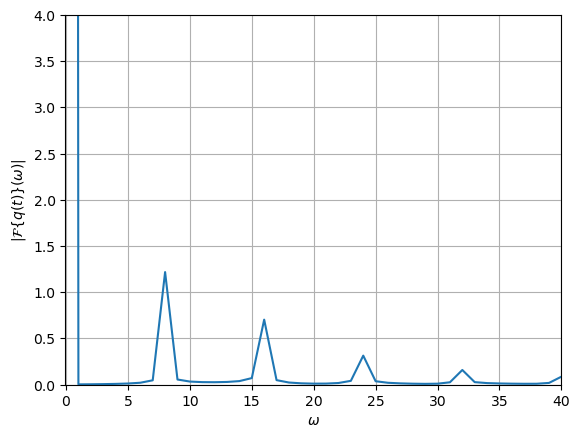

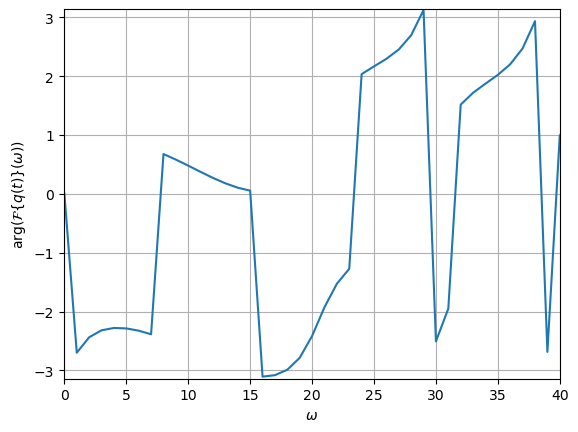

In [6]:
# https://docs.scipy.org/doc/scipy/tutorial/fft.html
qf = fft(q)


# https://stackoverflow.com/questions/63211851/why-divide-the-output-of-numpy-fft-by-n
plt.plot(tf[:len(tf)//2], 2 * np.abs(qf[:len(qf)//2]) / N )
plt.grid()
plt.xlim([-0.05,40])
plt.ylim([-0.001, 4])
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|\mathcal{F}\{q(t)\}(\omega)|$")
plt.show()

plt.plot(tf[:len(tf)//2], np.angle(qf[:len(qf)//2]))
plt.grid()
plt.xlim([-0.05,40])
plt.ylim([-3.14, 3.14])
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\operatorname{arg}(\mathcal{F}\{q(t)\}(\omega))$")
plt.show()

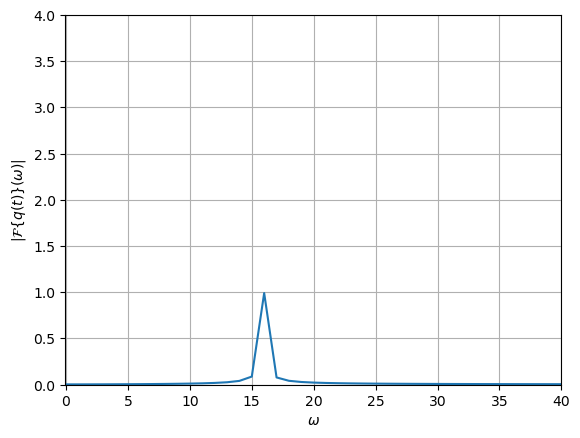

In [7]:


u = lambda t : eps_a * U_bar * np.sin(St * t)

uf = fft(u(t))

plt.plot(tf[:len(tf)//2], 2 * np.abs(uf[:len(uf)//2]) / N )
plt.grid()
plt.xlim([-0.05,40])
plt.ylim([-0.001, 4])
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|\mathcal{F}\{q(t)\}(\omega)|$")
plt.show()

In [19]:
def FTF_u(index: int):
    r"$0 \leq u < N$"
    return qf[index] * U_bar / (uf[index] * Q_bar)

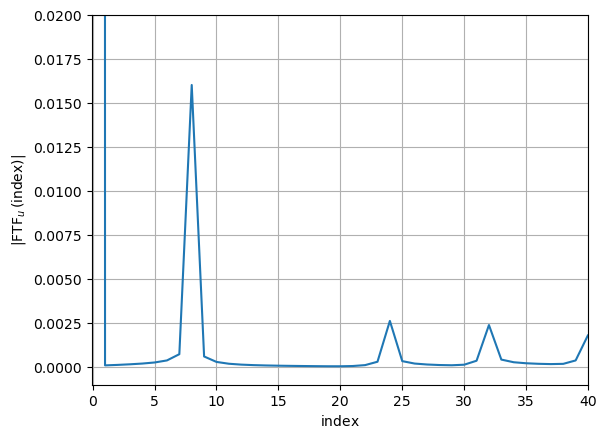

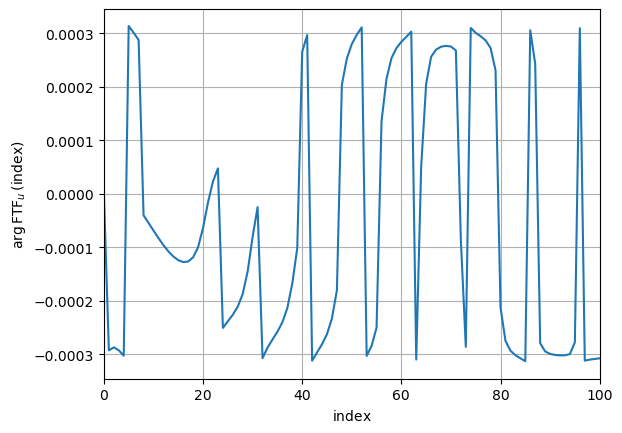

In [36]:
res = [FTF_u(i) for i in range(len(uf))]

plt.plot(tf[:len(tf)//2], np.abs(res[:len(res)//2]) / N )
plt.grid()
plt.xlim([-0.05,40])
plt.ylim([-0.001, 0.02])
plt.xlabel(r"$\text{index}$")
plt.ylabel(r"$|\operatorname{FTF}_u(\text{index})|$")
plt.show()


plt.plot(tf[:len(tf)//2], np.angle(res[:len(res)//2]) / N )
plt.grid()
plt.xlim([-0.05,100])
# plt.ylim([-0.001, 0.02])
plt.xlabel(r"$\text{index}$")
plt.ylabel(r"$\operatorname{arg}\operatorname{FTF}_u(\text{index})$")
plt.show()